# **Random Forest Classification**
Use a labeled dataset with categorical labels (e.g. messages labeled as spam or not spam, tumors
labeled as cancerous or not cancerous etc.) and build a random forest classifier to predict future
data. Split your data into train and test data, evaluate the model’s performance and discuss
ways to improve it

**Student Performance Classification Using Random Forest**


In this project, I use the Students Academic Performance Dataset from Kaggle. It contains data about 1,000 students, including their background, parents’ education, lunch type, test preparation, and exam scores in math, reading, and writing.

Project Goal

The goal is to build a Random Forest model that predicts whether a student will pass or fail an exam in a chosen subject.
A score of 50 or higher is considered a pass.

What I analyze

how different background factors affect student performance,

which features are the most important for predicting success,

how well the Random Forest model can classify pass/fail outcomes.

This project includes data exploration, visualizations, preprocessing, and machine learning to better understand what influences student achievement

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)


plt.style.use("seaborn-v0_8")

In [9]:
from google.colab import drive
drive.mount('/StudentsPerformance.csv')

Mounted at /StudentsPerformance.csv


## Download data



In [10]:

DATA_PATH = "StudentsPerformance.csv"

data = pd.read_csv(DATA_PATH)
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [11]:
print("Форма датасету (rows, columns):", data.shape)
print("\nСтовпці:\n", data.columns.to_list())

print("\nІнформація про стовпці:")
print(data.info())

print("\nБазова статистика для балів:")
print(data[["math score", "reading score", "writing score"]].describe())

Форма датасету (rows, columns): (1000, 8)

Стовпці:
 ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score']

Інформація про стовпці:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
None

Базова статистика для балів:
       math score

Exploratory Data Analysis

I explore the distribution of scores for each subject, look at how the scores are related to each other, and compare the results across different groups such as gender and other categorical features.

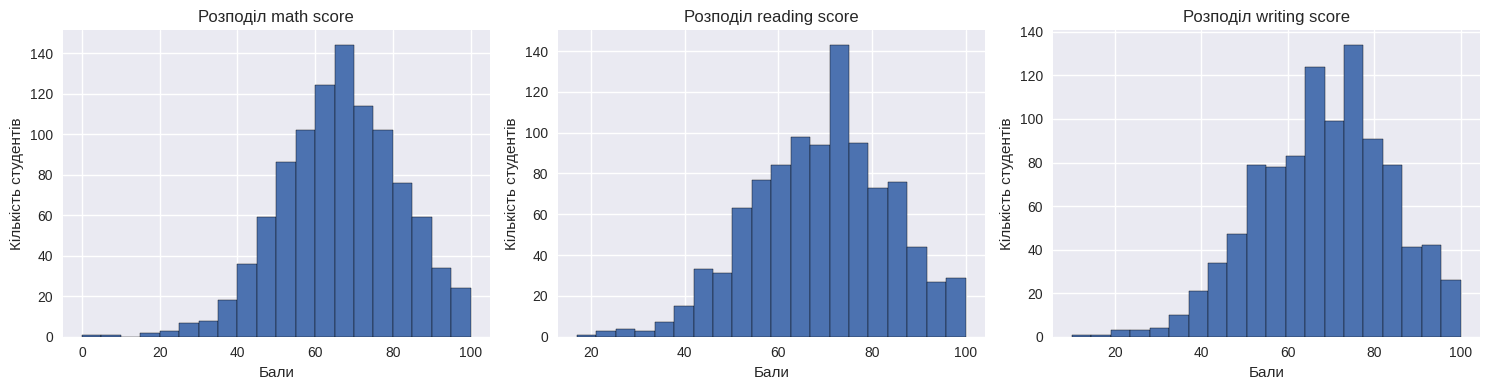

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
subjects = ["math score", "reading score", "writing score"]

for ax, subj in zip(axes, subjects):
    ax.hist(data[subj], bins=20, edgecolor="black")
    ax.set_title(f"Розподіл {subj}")
    ax.set_xlabel("Бали")
    ax.set_ylabel("Кількість студентів")

plt.tight_layout()
plt.show()

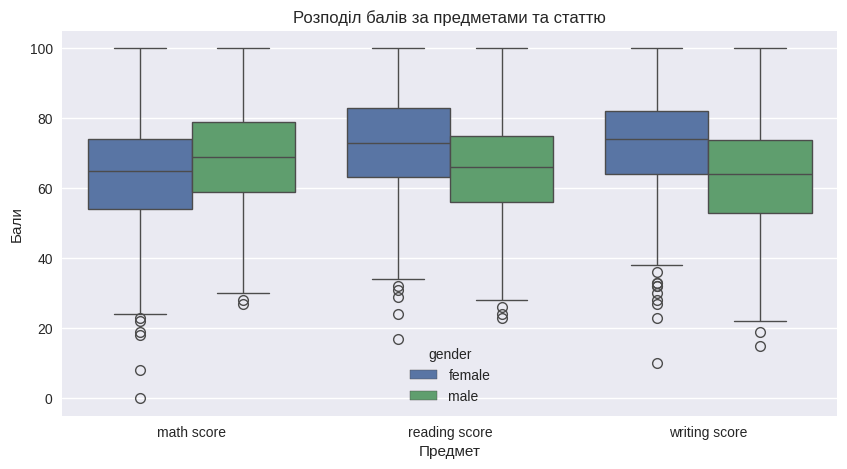

In [13]:

long_df = data.melt(
    id_vars=["gender"],
    value_vars=["math score", "reading score", "writing score"],
    var_name="subject",
    value_name="score"
)

plt.figure(figsize=(10, 5))
sns.boxplot(data=long_df, x="subject", y="score", hue="gender")
plt.title("Розподіл балів за предметами та статтю")
plt.xlabel("Предмет")
plt.ylabel("Бали")
plt.show()

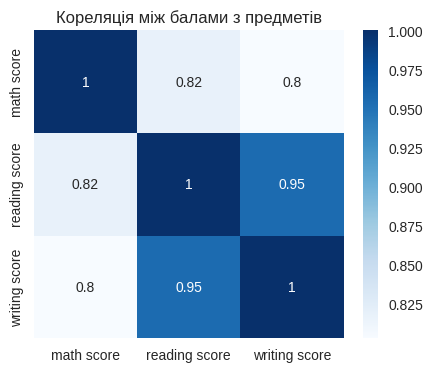

In [14]:

plt.figure(figsize=(5, 4))
corr = data[["math score", "reading score", "writing score"]].corr()
sns.heatmap(corr, annot=True, cmap="Blues")
plt.title("Кореляція між балами з предметів")
plt.show()

Choosing the Subject for Classification

To make the analysis flexible, I use a variable called TARGET_SUBJECT, where I can select one of the subjects: "math score","reading score", "writing score"

For the chosen subject, I create: numeric column target_score (a copy of the selected score column),
variable pass_target, where:
1 means the student passed (score ≥ threshold),
0 means the student failed (score < threshold).

In [15]:
TARGET_SUBJECT = "math score"   # можна змінити на "reading score" або "writing score"

PASS_THRESHOLD = 50

data["target_score"] = data[TARGET_SUBJECT]
data["pass_target"] = (data["target_score"] >= PASS_THRESHOLD).astype(int)

data[["target_score", "pass_target"]].head()

,target_score,pass_target
0,72,1
1,69,1
2,90,1
3,47,0
4,76,1


Analysis of the Selected Subject

In this step, I chosen TARGET_SUBJECT and explore how the pass rate (pass_target = 1) changes across different features.

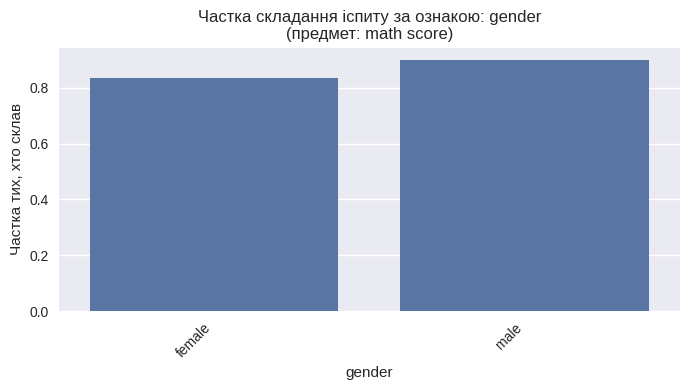

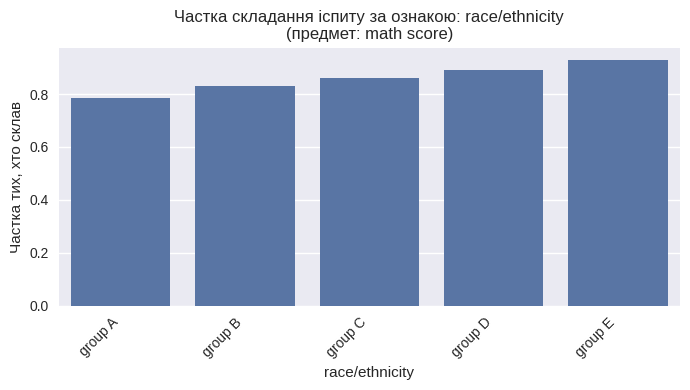

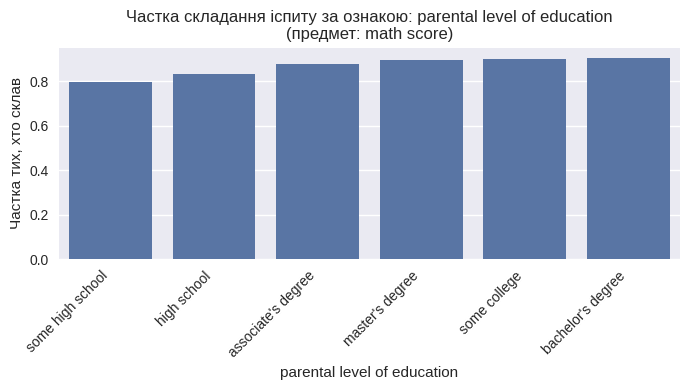

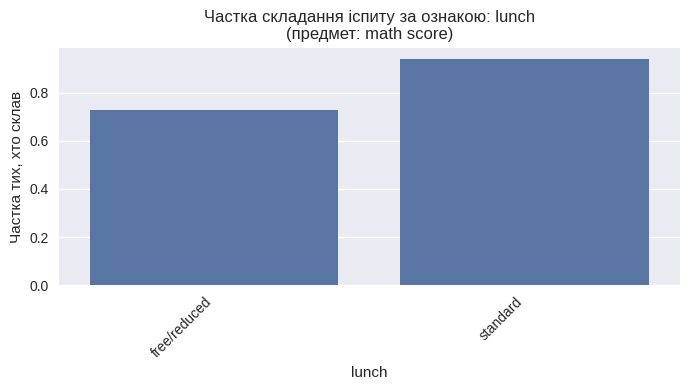

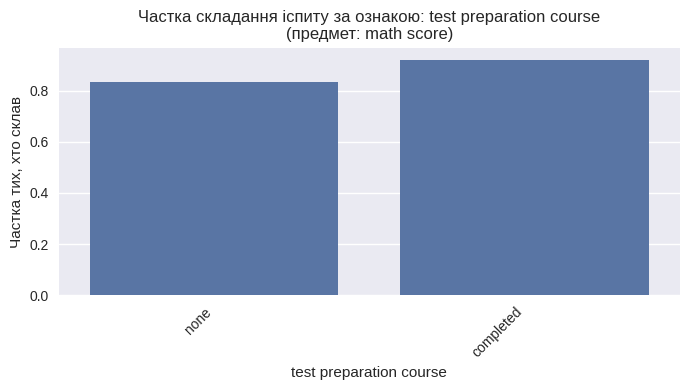

In [16]:
categorical_cols = [
    "gender",
    "race/ethnicity",
    "parental level of education",
    "lunch",
    "test preparation course"
]

for col in categorical_cols:
    plt.figure(figsize=(7, 4))
    pass_rate = data.groupby(col)["pass_target"].mean().sort_values()
    sns.barplot(x=pass_rate.index, y=pass_rate.values)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Частка тих, хто склав")
    plt.title(f"Частка складання іспиту за ознакою: {col}\n(предмет: {TARGET_SUBJECT})")
    plt.tight_layout()
    plt.show()

Data Preparation for the Random Forest Model

For the input features, I use:

gender

race/ethnicity

parental level of education

lunch

test preparation course

the scores from all three subjects (math score, reading score, writing score)

The target variable is pass_target.

Since several features are categorical, I apply one-hot encoding using pandas.get_dummies.
After that, I split the data into training and testing sets.


In [17]:
feature_cols = [
    "gender",
    "race/ethnicity",
    "parental level of education",
    "lunch",
    "test preparation course",
    "math score",
    "reading score",
    "writing score"
]

X = data[feature_cols]
y = data["pass_target"]

X_encoded = pd.get_dummies(X, drop_first=True)

print("Розмірність до кодування:", X.shape)
print("Розмірність після кодування:", X_encoded.shape)
X_encoded.head()

Розмірність до кодування: (1000, 8)
Розмірність після кодування: (1000, 15)


,math score,reading score,writing score,gender_male,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school,lunch_standard,test preparation course_none
0,72,72,74,False,True,False,False,False,True,False,False,False,False,True,True
1,69,90,88,False,False,True,False,False,False,False,False,True,False,True,False
2,90,95,93,False,True,False,False,False,False,False,True,False,False,True,True
3,47,57,44,True,False,False,False,False,False,False,False,False,False,False,True
4,76,78,75,True,False,True,False,False,False,False,False,True,False,True,True


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Розмір train:", X_train.shape[0])
print("Розмір test:", X_test.shape[0])

Розмір train: 800
Розмір test: 200


Building the Random Forest Model

For classification, I use the RandomForestClassifier from the scikit-learn library with the following basic hyperparameters:

n_estimators = 200 — number of trees in the forest,

max_depth = None — no limit on tree depth,

random_state = 42 — ensures reproducible results.

In the future, the model can be improved by tuning its hyperparameters.

In [19]:
rf_clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

The model is evaluated using: accuracy (the proportion of correct predictions), classification report (precision, recall, F1-score), confusion matrix, visualized as a heatmap.


In [20]:
y_pred = rf_clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy для предмета {TARGET_SUBJECT}: {acc:.4f}\n")

print("Classification report:")
print(classification_report(y_test, y_pred))

Accuracy для предмета math score: 1.0000

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00       173

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



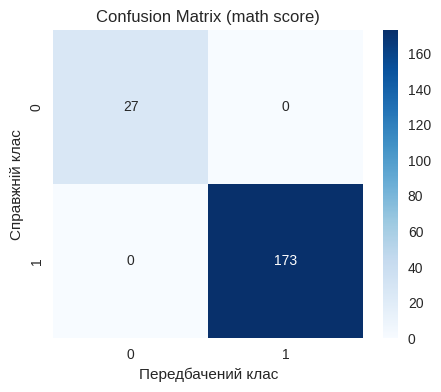

In [21]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix ({TARGET_SUBJECT})")
plt.xlabel("Передбачений клас")
plt.ylabel("Справжній клас")
plt.show()

One of the advantages of Random Forest is the ability to measure feature importance. This shows which factors have the strongest impact on whether a student passes the exam.

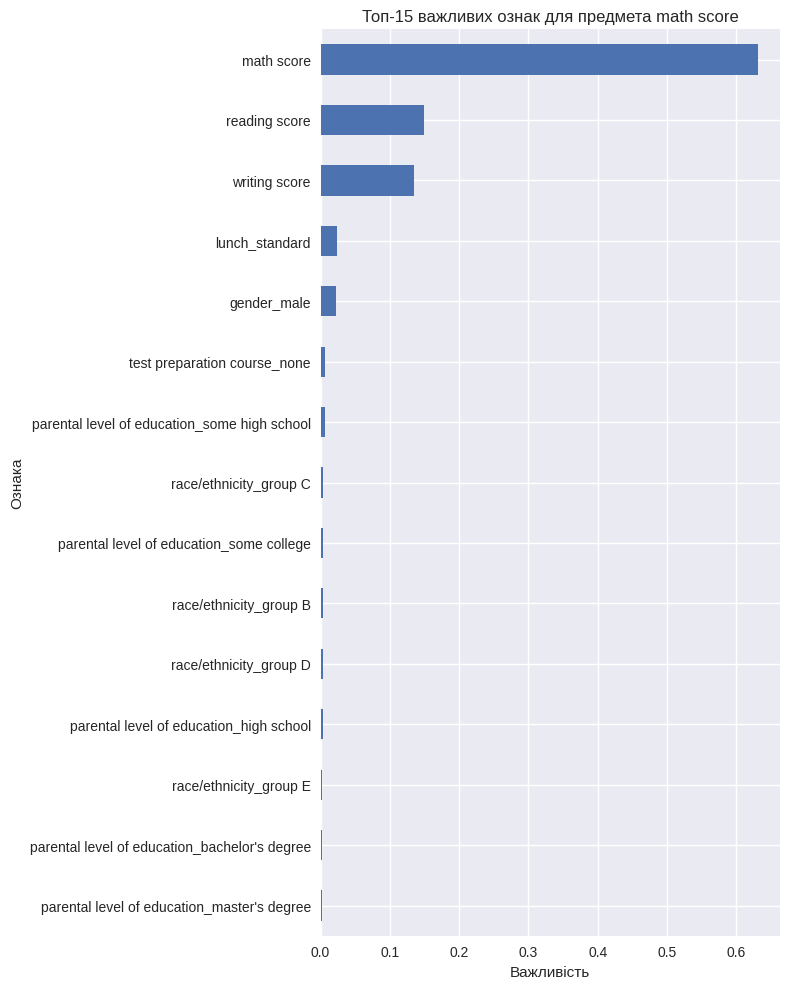

,0
math score,0.631680
reading score,0.148865
writing score,0.134263
lunch_standard,0.024066
gender_male,0.021728
test preparation course_none,0.006419
parental level of education_some high school,0.006184
race/ethnicity_group C,0.004221
parental level of education_some college,0.004162
race/ethnicity_group B,0.004098


In [22]:
importances = rf_clf.feature_importances_
feature_names = X_encoded.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8, 10))
feat_imp.head(15).sort_values().plot(kind="barh")
plt.title(f"Топ-15 важливих ознак для предмета {TARGET_SUBJECT}")
plt.xlabel("Важливість")
plt.ylabel("Ознака")
plt.tight_layout()
plt.show()

feat_imp.head(15)

**Conclusions**

In this project, a Random Forest model was built to predict whether a student will pass an exam in a selected subject (math score, reading score, or writing score) based on demographic and academic features.

Main findings

The model achieved an accuracy of approximately (insert actual value) for the chosen subject TARGET_SUBJECT.

The most important features included:

*  scores in other subjects,
*  several socioeconomic factors such as parental education level, lunch type, and test preparation course.


These results suggest that both a student’s overall academic level and their background can strongly influence exam performance.

**Possible improvements**

The model can be improved by:

1. Hyperparameter tuning (e.g., using GridSearchCV or RandomizedSearchCV),

2. Trying different values of PASS_THRESHOLD,

3. Comparing Random Forest with alternative models (such as Gradient Boosting or XGBoost),

4. Addressing potential class imbalance using class weights or resampling techniques.

Overall, Random Forest proved to be a strong and interpretable model for analyzing student performance and identifying the factors that most affect exam success.